# Validation

In [1]:
# import libraries
import os
import ROOT
import numpy as np
from scipy import stats
from tableauColors import palette

Welcome to JupyROOT 6.18/00


## 0. Create dataframes

In [2]:
# helpers
def leakageCorrection(col):
    return f"{col}*PrimaryEnergy/(PrimaryEnergy-LateralLeakage)"

def modifiedZscore(rdf, col, D=3.5):
    x = rdf.AsNumpy(columns=[col])[col]
    xtilde = np.median(x)
    MAD = np.median(np.abs(x-xtilde))
    return f"abs(0.6745*({col}-({xtilde}))/{MAD}) <= {D}"

In [3]:
treeName = "B4"
path = "/groups/hep/mojen/repositories/DREAM/Run/final_run/range"

In [4]:
# create rdataframe
fileName = os.path.join(path, "range.root")
rdf = ROOT.ROOT.RDataFrame(treeName, os.path.join(path, fileName))
print(rdf.GetColumnNames())

{ "PrimaryPDG", "PrimaryEnergy", "PrimaryDecayMode", "LateralLeakage", "AbsorberMaterial", "VoxelsAlongY", "VecShowerPDG", "VecShowerCharge", "VecShowerPosition", "VecShowerEnergy", "VecShowerMomentum", "VecShowerCkovCoMi", "VecShowerCkovCoMj", "VecShowerScntCoMi", "VecShowerScntCoMj", "VecIndexCkov", "VecSignalCkov", "VecIndexScnt", "VecSignalScnt" }


## 1. Performance

### Energy resolution

In [5]:
cal = np.load("calibration.pkl.npy", allow_pickle=True).item()

In [6]:
rdf2 = rdf
# rdf2 = rdf2.Filter("( > 10000) && (VecShowerEnergy.at(0)) < 25000")
rdf2 = rdf2.Define("VecSignalScnt_corr", leakageCorrection("VecSignalScnt"))
rdf2 = rdf2.Define("VecSignalCkov_corr", leakageCorrection("VecSignalCkov"))
rdf2 = rdf2.Define("VecSignalScnt_cal", f"VecSignalScnt*{cal['Scnt']}")
rdf2 = rdf2.Define("VecSignalCkov_cal", f"VecSignalCkov*{cal['Ckov']}")
rdf2 = rdf2.Define("Snorm", f"Sum(VecSignalScnt_cal) / PrimaryEnergy")
rdf2 = rdf2.Define("Cnorm", f"Sum(VecSignalCkov_cal) / PrimaryEnergy")
rdf2 = rdf2.Define("CoverS", "Cnorm/Snorm")
rdf2_e = rdf2.Filter("PrimaryPDG == 11", "electron")
rdf2_pi = rdf2.Filter("PrimaryPDG == -211", "pion")
# print cuts report
# cutsReport = rdf_energy_pi.Report()
# cutsReport.Print()

### C/E vs. S/E

In [7]:
rdf3_e = rdf2_e.Filter("PrimaryEnergy > 75000 && PrimaryEnergy < 85000")
rdf3_pi = rdf2_pi.Filter("PrimaryEnergy > 75000 && PrimaryEnergy < 85000")
# modified Z score
rdf3_e = rdf3_e.Filter(modifiedZscore(rdf3_e, "Snorm")+"&&"+modifiedZscore(rdf3_e, "Cnorm"), "Cut2")
rdf3_pi = rdf3_pi.Filter(modifiedZscore(rdf3_pi, "Snorm")+"&&"+modifiedZscore(rdf3_pi, "Cnorm"), "Cut2")

In [8]:
# correlation coefficients
SC_e = rdf3_e.AsNumpy(columns=["Snorm", "Cnorm"])
SC_pi = rdf3_pi.AsNumpy(columns=["Snorm", "Cnorm"])
print(stats.pearsonr(x=SC_e['Snorm'], y=SC_e['Cnorm']))
print(stats.pearsonr(x=SC_pi['Snorm'], y=SC_pi['Cnorm']))

(-0.09624381064914403, 0.002079273436710897)
(0.7192258052735095, 8.213054549849553e-161)


In [9]:
# rotation method
gr = rdf3_pi.Graph("Snorm", "Cnorm")
# linear fit
r = gr.Fit("pol1", "S")


****************************************
Minimizer is Linear
Chi2                      =      5.78111
NDf                       =         1003
p0                        =    -0.549799   +/-   0.034857    
p1                        =      1.29013   +/-   0.0393516   


In [10]:
p0 = r.Parameter(0)
p1 = r.Parameter(1)
X = p0/(1-p1)
theta = np.pi/2 - np.arctan(p1)
print(p0, p1, X, theta*180/np.pi)

-0.5497990908170064 1.2901297917478465 1.8950108070764413 37.779829634925235


In [11]:
rotate_xcoord_code = '''
double rotate_xcoord(double x, double y, double angle, double cx) {
    double s = sin(angle);
    double c = cos(angle);
    x -= cx;
    y -= cx;
    double xnew = x * c - y * s;
    double ynew = x * s + y * c;
    x = xnew + cx;
    y = ynew + cx;
    return x;
};
'''
ROOT.gInterpreter.Declare(rotate_xcoord_code)
rotate_ycoord_code = '''
double rotate_ycoord(double x, double y, double angle, double cx) {
    double s = sin(angle);
    double c = cos(angle);
    x -= cx;
    y -= cx;
    double xnew = x * c - y * s;
    double ynew = x * s + y * c;
    x = xnew + cx;
    y = ynew + cx;
    return y;
};
'''
ROOT.gInterpreter.Declare(rotate_ycoord_code)

True

In [12]:
rdf3_pi = rdf3_pi.Define("PivotPoint", str(X))
rdf3_pi = rdf3_pi.Define("PivotAngle", str(theta))
rdf3_pi = rdf3_pi.Define("Snorm_rot", "rotate_xcoord(Snorm, Cnorm, PivotAngle, PivotPoint)")
rdf3_pi = rdf3_pi.Define("Cnorm_rot", "rotate_ycoord(Snorm, Cnorm, PivotAngle, PivotPoint)")

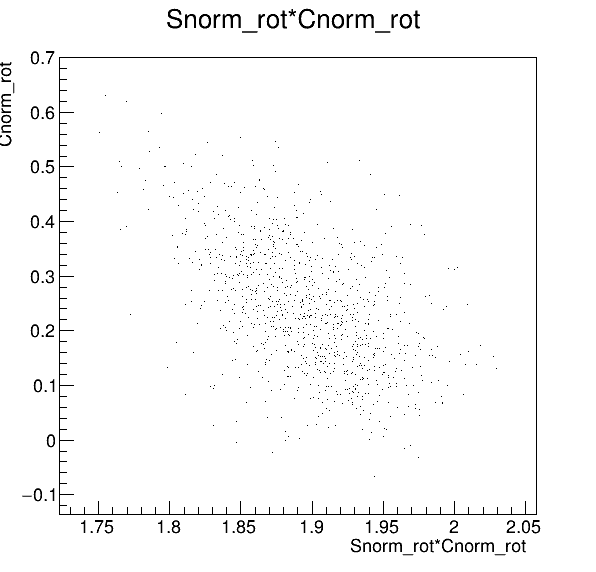

In [13]:
c1 = ROOT.TCanvas("c1", "c1", 600, 600)
gr = rdf3_pi.Graph("Snorm_rot", "Cnorm_rot")
gr.Draw("ap")
c1.Draw()

 FCN=32.0112 FROM MIGRAD    STATUS=CONVERGED      62 CALLS          63 TOTAL
                     EDM=9.9932e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.73226e+01   1.47959e+00   3.35690e-03   1.01728e-04
   2  Mean         1.89614e+00   1.47753e-03   4.14122e-06   2.85208e-01
   3  Sigma        4.54457e-02   1.08714e-03   1.78514e-05  -2.50976e-03


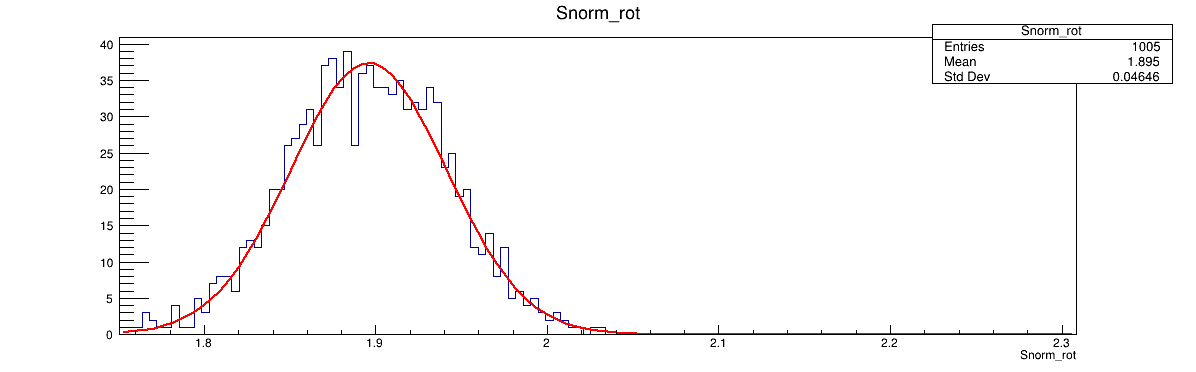

In [14]:
c5 = ROOT.TCanvas("c5", "c5", 1200, 400)
h5c = rdf3_pi.Histo1D("Snorm_rot")
h5c.Draw()
rc = h5c.Fit("gaus", "S")
c5.Draw()

In [15]:
rdf3_pi = rdf3_pi.Define("reconstructed_energy", f"(Snorm-{cal['chi']}*Cnorm)/(1-{cal['chi']})")

 FCN=60.4877 FROM MIGRAD    STATUS=CONVERGED      70 CALLS          71 TOTAL
                     EDM=1.72953e-11    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.26296e+01   1.81660e+00   5.31086e-03  -7.23630e-07
   2  Mean         9.95208e-01   1.86772e-03   7.04561e-06   2.11601e-03
   3  Sigma        5.59152e-02   1.56986e-03   2.57895e-05  -6.53245e-04


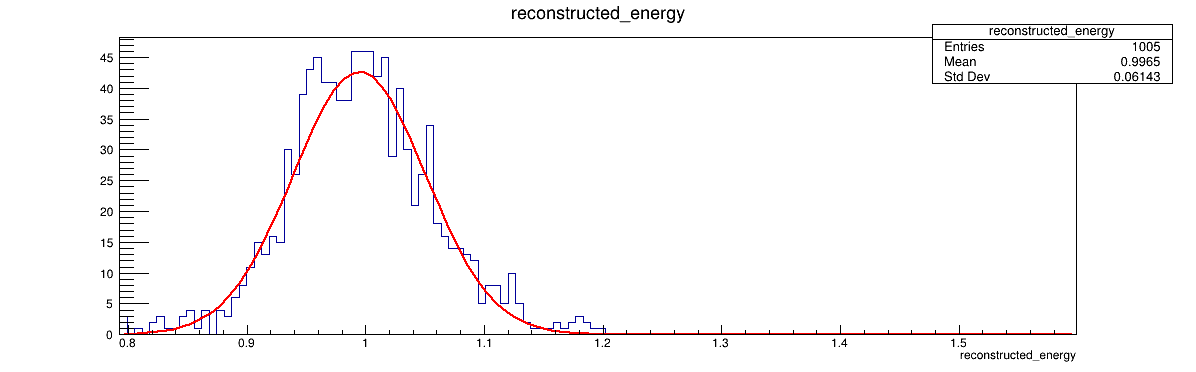

In [16]:
c5 = ROOT.TCanvas("c5", "c5", 1200, 400)
h5c = rdf3_pi.Histo1D("reconstructed_energy")
h5c.Draw()
rc = h5c.Fit("gaus", "S")
c5.Draw()

In [17]:
# C/E vs S/E
gr1 = rdf3_e.Graph("Snorm", "Cnorm")
gr2 = rdf3_pi.Graph("Snorm", "Cnorm")
gr1.SetMarkerColor(palette['blue'].GetNumber())
gr2.SetMarkerColor(palette['red'].GetNumber())
gr1.SetMarkerStyle(ROOT.kFullDotSmall)
gr2.SetMarkerStyle(ROOT.kFullDotSmall)

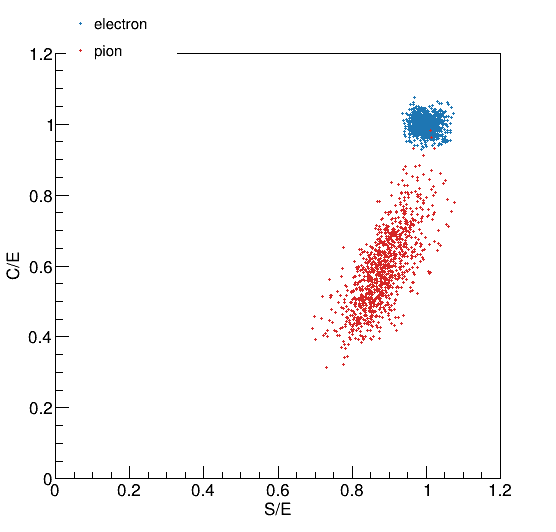

In [268]:
ratio = 7/3
nbins = 40
c1 = ROOT.TCanvas("c1", "c1", 560, 560)
# c1.SetRightMargin(0.)
# c1.SetTopMargin(0.)
mg = ROOT.TMultiGraph()
mg.Add(gr1.GetPtr())
mg.Add(gr2.GetPtr())
mg.Draw("ap")
mg.GetXaxis().SetTitle("S/E")
mg.GetYaxis().SetTitle("C/E")
mg.GetXaxis().CenterTitle()
mg.GetYaxis().CenterTitle()
mg.SetMinimum(0)
mg.SetMaximum(1.2)
mg.GetXaxis().SetLimits(0, 1.2)

# 
labelsize = 1.2 * mg.GetYaxis().GetLabelSize()
titlesize = 1.4 * mg.GetYaxis().GetTitleSize()
xtitleoffset = 1.2 * mg.GetXaxis().GetTitleOffset()
ytitleoffset = 0.9 * xtitleoffset
xlabeloffset = 2 * mg.GetXaxis().GetLabelOffset()
ylabeloffset = 1.5 * mg.GetYaxis().GetLabelOffset()
linewidth = 2
ticklength = 0.02

# add legend
legend = ROOT.TLegend(0.12, 0.88, 0.32, 0.98)
legend.SetFillColor(0)
legend.SetBorderSize(0)
legend.SetTextSize(0.03)
legend.AddEntry(gr1.GetValue(), "electron", "p")
legend.AddEntry(gr2.GetValue(), "pion", "p")
legend.Draw()
c1.Draw()
c1.Print("hXY.png")

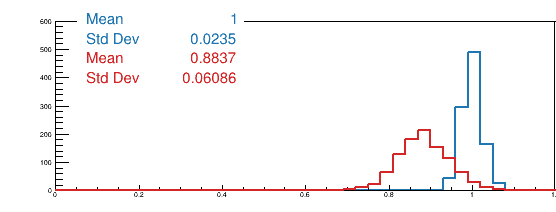

In [267]:
c2 = ROOT.TCanvas("c1", "c1", 560, 240)
ROOT.gStyle.SetOptStat("mr")
c2.SetRightMargin(0.)
# c2.SetTopMargin(0.)
modelX = ("", "", nbins, mg.GetXaxis().GetXmin(), mg.GetXaxis().GetXmax())
hX_e = rdf3_e.Histo1D(modelX, "Snorm")
hX_pi = rdf3_pi.Histo1D(modelX, "Snorm")
hX_e.SetFillStyle(0)
hX_e.SetLineColor(palette['blue'].GetNumber())
hX_pi.SetFillStyle(0)
hX_pi.SetLineColor(palette['red'].GetNumber())
# hX.GetXaxis().SetLabelOffset(999)
# hX.GetXaxis().SetLabelSize(0)
# hX.GetYaxis().SetLabelSize(mg.GetYaxis().GetLabelSize()*ratio)
#rX = hX_pi.Fit("gaus", "S")
#hX.SetStats(False)

hX_e.SetLineWidth(linewidth)
hX_pi.SetLineWidth(linewidth)

hX_e.Draw()
hX_pi.Draw("sames")

c2.Update()

# stat box
stats1 = hX_e.GetListOfFunctions().FindObject("stats")
hX_e.GetListOfFunctions().Remove(stats1)
hX_e.SetStats(0)
stats1.SetTextColor(palette['blue'].GetNumber())

stats1.SetX1NDC(0.1+2*ticklength)
stats1.SetY2NDC(1-2*ticklength)
stats1.SetX2NDC(stats1.GetX1NDC()+0.3)
stats1.SetY1NDC(stats1.GetY2NDC()-0.1*520/280)
stats1.SetTextSize(labelsize*520/280)
stats1.SetBorderSize(0)
stats1.GetListOfLines().Remove(stats1.GetLineWith("Mean y"))
stats1.Draw()
hX_e.SetStats(0)

stats2 = hX_pi.GetListOfFunctions().FindObject("stats")
hX_pi.GetListOfFunctions().Remove(stats2)
hX_pi.SetStats(0)
stats2.SetTextColor(palette['red'].GetNumber())
stats2.SetX2NDC(stats1.GetX2NDC())
stats2.SetY2NDC(stats1.GetY1NDC())
stats2.SetX1NDC(stats1.GetX1NDC())
stats2.SetY1NDC(stats1.GetY1NDC()-0.1*520/280)
stats2.SetTextSize(labelsize*520/280)
stats2.SetBorderSize(0)
stats2.Draw()
hX_pi.SetStats(0)

hX_e.SetAxisRange(0., 600., "Y")

c2.Draw()
c2.Print("hX.png")

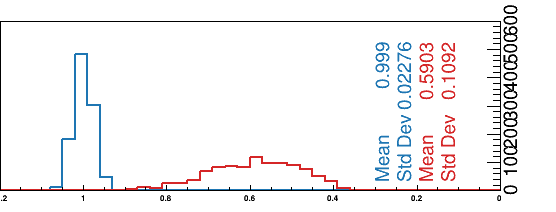

In [265]:
c3 = ROOT.TCanvas("c3", "c3", 560, 240)
ROOT.gStyle.SetOptStat(0)
c3.SetLeftMargin(0.)
# c3.SetTopMargin(0.)
xmin = mg.GetYaxis().GetXmin()
xmax = mg.GetYaxis().GetXmax()
modelY = ("", "", nbins, xmin, xmax)
rdf_energy_pi_rev = rdf3_pi
rdf_energy_pi_rev = rdf_energy_pi_rev.Define("reversedCnorm_cal", f"{xmax}-Cnorm+{xmin}")
rdf_energy_e_rev = rdf3_e
rdf_energy_e_rev = rdf_energy_e_rev.Define("reversedCnorm_cal", f"{xmax}-Cnorm+{xmin}")
hY_e = rdf_energy_e_rev.Histo1D(modelY, "reversedCnorm_cal")
hY_e.SetFillStyle(0)
hY_e.SetLineColor(palette['blue'].GetNumber())
hY_pi = rdf_energy_pi_rev.Histo1D(modelY, "reversedCnorm_cal")
hY_pi.SetFillStyle(0)
hY_pi.SetLineColor(palette['red'].GetNumber())
#hY_pi.GetYaxis().SetLabelSize(mg.GetYaxis().GetLabelSize()*ratio)

#rY = hY.Fit("gaus", "S")
#hY.SetStats(False)
hY_e.Draw("Y+")
hY_pi.Draw("sames")

hY_e.SetLineWidth(linewidth)
hY_pi.SetLineWidth(linewidth)

labelsize2 = 560/240*labelsize

legend1 = ROOT.TLatex()
legend1.SetTextAngle(90)
legend1.SetTextSize(labelsize2)
legend1.SetTextFont(42)
legend1.SetTextColor(palette['blue'].GetNumber())
legend1.DrawTextNDC(0.70, 0.14, "Mean")
legend1.DrawTextNDC(0.74, 0.14, "Std Dev")

legend2 = ROOT.TLatex()
legend2.SetTextAngle(90)
legend2.SetTextSize(labelsize2)
legend2.SetTextFont(42)
legend2.SetTextColor(palette['red'].GetNumber())
legend2.DrawTextNDC(0.78, 0.14, "Mean")
legend2.DrawTextNDC(0.82, 0.14, "Std Dev")

legend3 = ROOT.TLatex()
legend3.SetTextAngle(90)
legend3.SetTextSize(labelsize2)
legend3.SetTextFont(42)
legend3.SetTextColor(palette['blue'].GetNumber())
legend3.SetTextAlign(31)
legend3.DrawTextNDC(0.70, 0.8, f"{xmax-hY_e.GetMean()+xmin:.4g}")
legend3.DrawTextNDC(0.74, 0.8, f"{hY_e.GetRMS():.4g}")

legend4 = ROOT.TLatex()
legend4.SetTextAngle(90)
legend4.SetTextSize(labelsize2)
legend4.SetTextFont(42)
legend4.SetTextColor(palette['red'].GetNumber())
legend4.SetTextAlign(31)
legend4.DrawTextNDC(0.78, 0.8, f"{xmax-hY_pi.GetMean()+xmin:.4g}")
legend4.DrawTextNDC(0.82, 0.8, f"{hY_pi.GetRMS():.4g}")

# Remove the current axis
hY_e.GetXaxis().SetLabelOffset(999)
hY_e.GetXaxis().SetTickLength(0)
hY_e.SetAxisRange(0., 600., "Y")
hY_e.GetYaxis().SetLabelSize(labelsize2)

# Redraw the new axis
ROOT.gPad.Update()
newaxis = ROOT.TGaxis(ROOT.gPad.GetUxmax(), ROOT.gPad.GetUymin(),
                      ROOT.gPad.GetUxmin(), ROOT.gPad.GetUymin(),
                      xmin, xmax, 510, "-")
newaxis.SetLabelOffset(-0.03)
newaxis.Draw()

ROOT.gPad.Update()
for i in range(8):
    hY_e.GetYaxis().ChangeLabel(i, 90., -1, 23)
c3.Update()
c3.Draw()
c3.Print("hY.png")

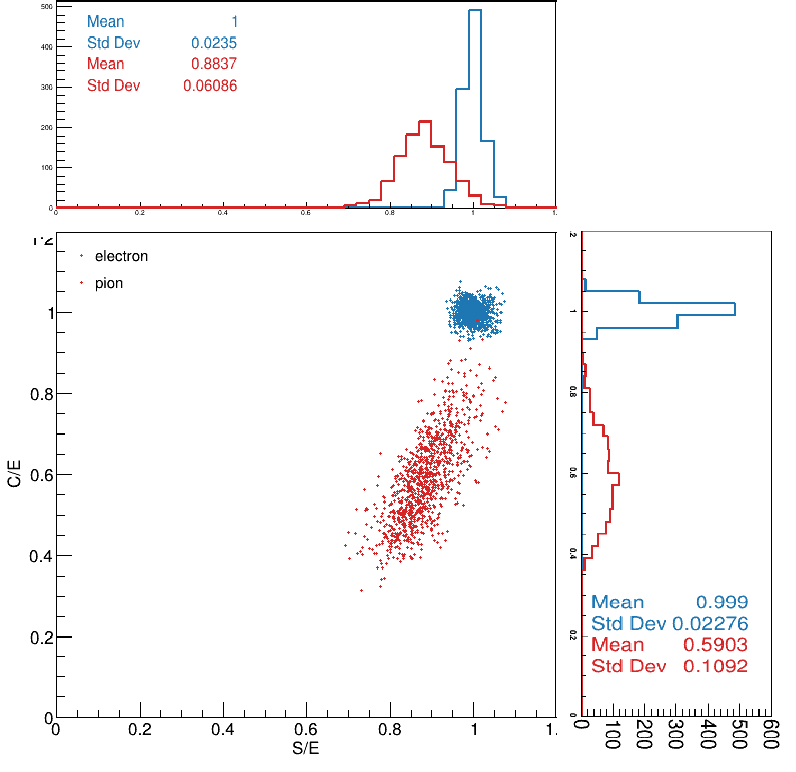

In [263]:
c4 = ROOT.TCanvas("c4", "c4", 800, 800)
pad1 = ROOT.TPad("pad1", "pad1", 0., 0., .7, .7); pad1.Draw()
pad2 = ROOT.TPad("pad2", "pad2", 0., .7, .7, 1.); pad2.Draw()
pad3 = ROOT.TPad("pad3", "pad3", .7, 0., 1., .7); pad3.Draw()
# pad1
pad1.cd()
h_img = ROOT.TImage.Open("hXY.png")
h_img.Draw("x")
pad1.Update()
# pad2
pad2.cd()
hX_img = ROOT.TImage.Open("hX.png")
hX_img.Draw("x")
pad2.Update()
# pad3
pad3.cd()
hY_img = ROOT.TImage.Open("hY.png")
hY_img.Flip(270)
hY_img.Draw("x")
pad3.Update()

c4.Update()
c4.Draw()
c4.Print("final.png")

### Particle identification

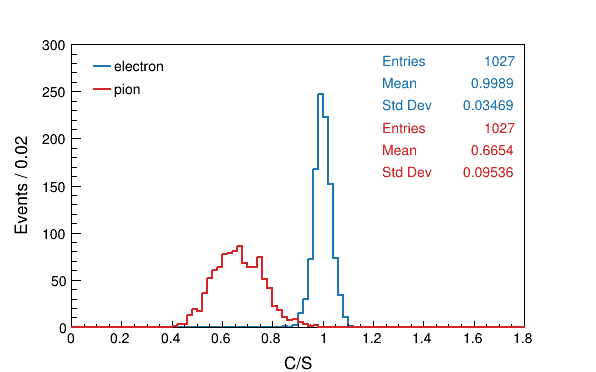

In [161]:
c6 = ROOT.TCanvas("c6", "c6", 600, 400)
ROOT.gPad.SetLeftMargin(0.12)
ROOT.gPad.SetBottomMargin(0.12)
ROOT.gPad.SetRightMargin(0.12)
ROOT.gPad.SetTopMargin(0.12)
ROOT.gStyle.SetOptStat("emr")

model = ("","", 90, 0., 1.8)
energyFilter = "PrimaryEnergy > 75000 && PrimaryEnergy < 85000"
h6_e = rdf2_e.Filter(energyFilter).Histo1D(model, "CoverS")
h6_pi = rdf2_pi.Filter(energyFilter).Histo1D(model, "CoverS")
h6_e.SetLineColor(palette['blue'].GetNumber())
h6_pi.SetLineColor(palette['red'].GetNumber())
h6_e.Draw()
h6_pi.Draw("sames")

labelsize = 1.2 * h6_e.GetYaxis().GetLabelSize()
titlesize = 1.4 * h6_e.GetYaxis().GetTitleSize()
xtitleoffset = 1.2 * h6_e.GetXaxis().GetTitleOffset()
ytitleoffset = 0.9 * xtitleoffset
xlabeloffset = 2 * h6_e.GetXaxis().GetLabelOffset()
ylabeloffset = 1.5 * h6_e.GetYaxis().GetLabelOffset()
linewidth = 2
ticklength = 0.02
x2ndc = 1-0.12
y2ndc = 1-0.12-0.012

h6_e.GetXaxis().SetTitle("C/S")
h6_e.GetXaxis().SetTitleSize(titlesize)
h6_e.GetXaxis().SetLabelSize(labelsize)
h6_e.GetXaxis().SetLabelOffset(xlabeloffset)
h6_e.GetXaxis().CenterTitle()
h6_e.GetXaxis().SetTitleOffset(xtitleoffset)
h6_e.GetXaxis().SetTickLength(ticklength)
binwidth = h6_e.GetBinWidth(1)
h6_e.SetAxisRange(0., 300., "Y")
h6_e.GetYaxis().SetTitle(f"Events / {binwidth}")
h6_e.GetYaxis().SetTitleSize(titlesize)
h6_e.GetYaxis().SetLabelSize(labelsize)
h6_e.GetYaxis().SetLabelOffset(ylabeloffset)
h6_e.GetYaxis().CenterTitle()
h6_e.GetYaxis().SetTitleOffset(ytitleoffset)
h6_e.GetYaxis().SetTickLength(ticklength)

h6_e.SetLineWidth(linewidth)
h6_pi.SetLineWidth(linewidth)

c6.Update()

# stat box
stats1 = h6_e.GetListOfFunctions().FindObject("stats")
h6_e.GetListOfFunctions().Remove(stats1)
h6_e.SetStats(0)
stats1.SetTextColor(palette['blue'].GetNumber())

stats1.SetX2NDC(x2ndc)
stats1.SetY2NDC(y2ndc)
stats1.SetX1NDC(stats1.GetX2NDC()-0.25)
stats1.SetY1NDC(stats1.GetY2NDC()-0.12*6/4)
stats1.SetTextSize(labelsize)
stats1.SetBorderSize(0)
stats1.GetListOfLines().Remove(stats1.GetLineWith("Mean y"))
stats1.Draw()
h6_e.SetStats(0)

stats2 = h6_pi.GetListOfFunctions().FindObject("stats")
h6_pi.GetListOfFunctions().Remove(stats2)
h6_pi.SetStats(0)
stats2.SetTextColor(palette['red'].GetNumber())
stats2.SetX2NDC(stats1.GetX2NDC())
stats2.SetY2NDC(stats1.GetY1NDC())
stats2.SetX1NDC(stats1.GetX1NDC())
stats2.SetY1NDC(stats1.GetY1NDC()-0.12*6/4)
stats2.SetTextSize(labelsize)
stats2.SetBorderSize(0)
stats2.Draw()
h6_pi.SetStats(0)

# add legend
legend = ROOT.TLegend(0.12+0.03, 1-0.12-0.03, 0.32, 1-0.12-0.15)
legend.SetFillColor(0)
legend.SetBorderSize(0)
legend.SetTextSize(labelsize)
legend.AddEntry(h6_e.GetValue(), "electron", "l")
legend.AddEntry(h6_pi.GetValue(), "pion", "l")
legend.Draw()

c6.Draw()

In [131]:
nentries = h6_e.GetNbinsX()
for i in range(int(nentries/2), nentries+1):
    if h6_e.Integral(i, nentries) != 0 and h6_pi.Integral(i, nentries):
        electron_efficiency = h6_e.Integral(i, nentries) / h6_e.Integral(1, nentries)
        pion_rejection_factor = h6_pi.Integral(0, i-1) / h6_pi.Integral(i, nentries)
        lowerEdge = h6_e.GetXaxis().GetBinLowEdge(i)
        print(i, f"{lowerEdge:.2f}", electron_efficiency, pion_rejection_factor)

35 0.68 1.0 1.3447488584474885
36 0.70 1.0 1.7756756756756757
37 0.72 1.0 2.3562091503267975
38 0.74 1.0 3.243801652892562
39 0.76 1.0 5.113095238095238
40 0.78 1.0 7.777777777777778
41 0.80 1.0 12.513157894736842
42 0.82 1.0 18.01851851851852
43 0.84 1.0 27.52777777777778
44 0.86 0.9990262901655307 38.5
45 0.88 0.9990262901655307 53.05263157894737
46 0.90 0.997078870496592 92.36363636363636
47 0.92 0.9824732229795521 170.16666666666666
48 0.94 0.9532619279454723 341.3333333333333
49 0.96 0.8831548198636806 512.5


## 3. Shower profiles

In [4]:
path = "/groups/hep/mojen/repositories/DREAM/Run/final_run/module"

In [5]:
getNij_code = '''
using namespace ROOT::VecOps;
RVec<int> getNi(RVec<int> v, int voxelsAlongY) {
    return v / voxelsAlongY;
};
RVec<int> getNj(RVec<int> v, int voxelsAlongY) {
    return v % voxelsAlongY;
};
'''
ROOT.gInterpreter.Declare(getNij_code)

True

In [6]:
getRadialDistance_code = '''
using namespace ROOT::VecOps;
RVec<double> getRadialDistance(const RVec<double> &x, const RVec<double> &y)
{ 
  auto mod = [](double x, double y) { return sqrt(x * x + y * y); };
  return Map(x, y, mod);
}
'''
ROOT.gInterpreter.Declare(getRadialDistance_code)

True

In [7]:
getArange_code ='''
using namespace ROOT::VecOps;
RVec<int> getArange(const int& a)
{ 
  RVec<int> v(a);
  std::iota(std::begin(v), std::end(v), 0);
  return v;
}
'''
ROOT.gInterpreter.Declare(getArange_code)

True

In [8]:
getRadialProfile_code ='''
using namespace ROOT::VecOps;
RVec<double> getRadialProfile(const RVec<double> &r, const RVec<double> &v1, const RVec<double> &xbins)
{
  double v2 = 0.;
  RVec<double> v(xbins.size());
  RVec<bool> c;
  RVec<double> if_c_v1_else_v2;
  for (size_t i = 0; i<xbins.size()-1; ++i) { 
    c = (r >= xbins.at(i)) && (r < xbins.at(i+1));
    if_c_v1_else_v2 = Where(c, v1, v2);
    v.at(i) = Sum(if_c_v1_else_v2);
  }
  return v;
}
'''
ROOT.gInterpreter.Declare(getRadialProfile_code)

True

In [9]:
# create dataframes
treeName = "B4"
rdf_profile = dict()
for s in ['10GeV', '40GeV']:
    fileName = os.path.join(path, f"{s}/{s}.root")
    rdf_profile[s] = ROOT.ROOT.RDataFrame(treeName, os.path.join(path, fileName))
    # define new columns
    rdf_profile[s] = rdf_profile[s].Define("VecSignalScnt_corr", leakageCorrection("VecSignalScnt"))
    rdf_profile[s] = rdf_profile[s].Define("VecSignalCkov_corr", leakageCorrection("VecSignalCkov"))

In [10]:
for s, v in zip(['10GeV', '40GeV'], ["Scnt", "Ckov"]):
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_i", f"getNi(VecIndex{v}, VoxelsAlongY)")
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_j", f"getNj(VecIndex{v}, VoxelsAlongY)")
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_x", f"{v}_j-VecShower{v}CoMj.at(0)")
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_y", f"{v}_i-VecShower{v}CoMi.at(0)")
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_norm", f"VecSignal{v}_corr/Sum(VecSignal{v}_corr)")    
#     rdf_profile[s] = rdf_profile[s].Define(f"{v}_norm", f"RVec<double>(VecSignal{v})/Sum(VecSignal{v})")    
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_r_mm", f"1.5*getRadialDistance({v}_x, {v}_y)")

In [11]:
binwidth = 0.6
xlow = 0.
xup = 1.5*np.sqrt(2*8**2)
nbins = int(np.ceil((xup-xlow)/binwidth))
xup = nbins*binwidth
print(nbins, xlow, xup)

29 0.0 17.4


Normalized signal INCLUDING under and overflow

The signal is leakage corrected (normalization makes calibration void)

The radial distance ($r_i$) between each individual fiber 𝑖 and the
shower axis was then determined as Eq. 3 Antonello2018

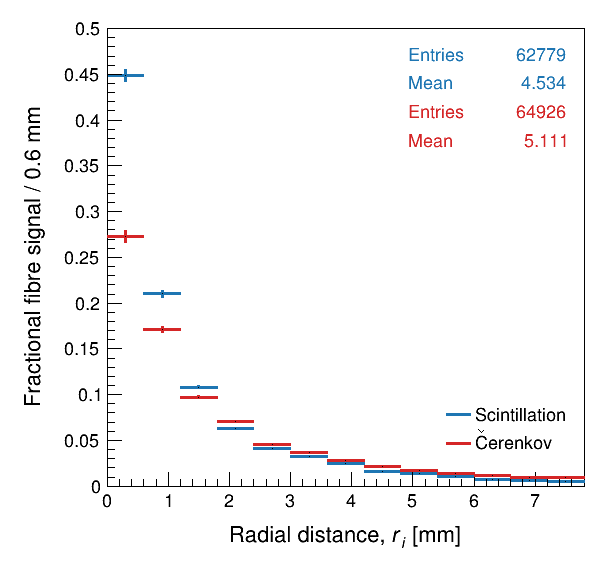

In [38]:
c8 = ROOT.TCanvas("c8", "c8", 600, 600)
ROOT.gStyle.SetOptStat("em")
x = ["Scnt_r_mm", "Ckov_r_mm"]
y = ["Scnt_norm", "Ckov_norm"]
p = [None, None]
model = ("", "", nbins, xlow, xup)
p[0] = rdf_profile['10GeV'].Profile1D(model, x[0], y[0])
p[1] = rdf_profile['40GeV'].Profile1D(model, x[1], y[1])
p[0].Draw()
p[1].Draw("sames")

#
p[0].SetLineColor(palette['blue'].GetNumber())
p[1].SetLineColor(palette['red'].GetNumber())
p[0].GetXaxis().SetTitle("Radial distance, #it{r_{i}} [mm]")
p[0].GetXaxis().SetRangeUser(0., 7.8)
p[0].GetYaxis().SetTitle(f"Fractional fibre signal / {binwidth} mm")
p[0].SetAxisRange(0., 0.5, "Y")

#
ROOT.gPad.SetLeftMargin(0.18)
ROOT.gPad.SetBottomMargin(0.15)
ROOT.gPad.SetRightMargin(0.02)
ROOT.gPad.SetTopMargin(0.05)

labelsize = 1 * p[0].GetYaxis().GetLabelSize()
titlesize = 1.2 * p[0].GetYaxis().GetTitleSize()
xtitleoffset = 1.3 * p[0].GetXaxis().GetTitleOffset()
ytitleoffset = 1.4 * xtitleoffset
xlabeloffset = 2 * p[0].GetXaxis().GetLabelOffset()
ylabeloffset = 2 * p[0].GetYaxis().GetLabelOffset()
linewidth = 3
x2ndc = 0.89+0.08
y2ndc = 0.88+0.05

p[0].SetLineWidth(linewidth)
p[1].SetLineWidth(linewidth)

p[0].GetXaxis().SetTitleSize(titlesize)
p[0].GetXaxis().SetLabelSize(labelsize)
p[0].GetXaxis().CenterTitle()
p[0].GetXaxis().SetTitleOffset(xtitleoffset)
p[0].GetXaxis().SetLabelOffset(xlabeloffset)

p[0].GetYaxis().SetTitleSize(titlesize)
p[0].GetYaxis().SetLabelSize(labelsize)
p[0].GetYaxis().CenterTitle()
p[0].GetYaxis().SetTitleOffset(ytitleoffset)
p[0].GetYaxis().SetLabelOffset(ylabeloffset)

c8.Update()

# stat box
stats1 = p[0].GetListOfFunctions().FindObject("stats")
p[0].GetListOfFunctions().Remove(stats1)
p[0].SetStats(0)
stats1.GetLineWith("Mean y").SetTextColor(0)
stats1.SetTextColor(palette['blue'].GetNumber())
stats1.SetX2NDC(x2ndc)
stats1.SetY2NDC(y2ndc)
stats1.SetX1NDC(stats1.GetX2NDC()-0.3)
stats1.SetY1NDC(stats1.GetY2NDC()-0.1)
stats1.SetTextSize(labelsize)
stats1.SetBorderSize(0)
stats1.GetListOfLines().Remove(stats1.GetLineWith("Mean y"))
stats1.Draw()
p[0].SetStats(0)

stats2 = p[1].GetListOfFunctions().FindObject("stats")
p[1].GetListOfFunctions().Remove(stats2)
p[1].SetStats(0)
stats2.SetTextColor(palette['red'].GetNumber())
stats2.SetX2NDC(stats1.GetX2NDC())
stats2.SetY2NDC(stats1.GetY1NDC())
stats2.SetX1NDC(stats1.GetX1NDC())
stats2.SetY1NDC(stats1.GetY1NDC()-0.1)
stats2.SetTextSize(labelsize)
stats2.SetBorderSize(0)
stats2.GetListOfLines().Remove(stats2.GetLineWith("Mean y"))
stats2.Draw()
p[1].SetStats(0)

# legend
legend = ROOT.TLegend(stats1.GetX1NDC()+0.07, 0.2, stats1.GetX2NDC(), 0.3)
legend.SetFillColor(0)
#legend.SetTextAlign(ROOT.kHAlignLeft+ROOT.kVAlignTop)
legend.SetBorderSize(0)
legend.SetTextSize(labelsize)
legend.AddEntry(p[0].GetValue(), "Scintillation", "l")
legend.AddEntry(p[1].GetValue(), "#check{C}erenkov", "l")
legend.Draw()

c8.Modified()

c8.Update()
c8.Draw()
c8.SaveAs("LateralProfile.png")